<a href="https://colab.research.google.com/github/vinacciam/pydda-colab/blob/main/argonne_pydda_workflow_may16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Dual-Doppler wind retrieval using PyDDA.
#Developed and tested on Google Colab.

In [ ]:
!pip install pydda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.46
    Uninstalling botocore-1.38.46:
      Successfully uninstalled botocore-1.38.46
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.23.1 requires botocore<1.38.47,>=1.38.40, but you have botocore 1.39.8 which is incompatible.


In [ ]:
import pydda
pydda.__file__
import os
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pyart
from pyart.testing import get_test_data

from pydda.initialization import make_constant_wind_field
from pydda.retrieval import get_dd_wind_field
from pydda.vis import plot_horiz_xsection_quiver

import boto3
import botocore
from botocore import UNSIGNED
from botocore.config import Config

warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Welcome to PyDDA 2.1.0
If you are using PyDDA in your publications, please cite:
Jackson et al. (2020) Journal of Open Research Science
Detecting Jax...
Jax/JaxOpt are not installed on your system, unable to use Jax engine.
Detecting TensorFlow...
TensorFlow detected. Checking for tensorflow-probability...
TensorFlow-probability detected. TensorFlow engine enabled!


In [ ]:
#To load in sounding data
from google.colab import files
uploaded = files.upload()

Saving morris-05-16-0000.csv to morris-05-16-0000.csv


In [ ]:
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
bucket_name = "noaa-nexrad-level2"

def list_nexrad_files(site, year, month, day, hour="00"):
    prefix = f"{year}/{month}/{day}/{site}/"
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    file_keys = []
    if "Contents" in response:
        for obj in response["Contents"]:
            key = obj["Key"]
            if f"{site}{year}{month}{day}_{hour}" in key:
                file_keys.append(key)
    print(f"Found {len(file_keys)} files for {site} on {year}-{month}-{day} at {hour}:00 UTC")
    for k in file_keys:
        print(k)
    return file_keys

def download_nexrad_file(s3_key, save_dir="radar_data"):
    os.makedirs(save_dir, exist_ok=True)
    filename = s3_key.split("/")[-1]
    local_path = os.path.join(save_dir, filename)
    print(f"Downloading {filename}...")
    s3.download_file(bucket_name, s3_key, local_path)
    print(f"Saved to {local_path}")
    return local_path
# get list of available files
klot_keys = list_nexrad_files("KLOT", "2025", "05", "16", hour="00")
tord_keys = list_nexrad_files("TORD", "2025", "05", "16", hour="00")

Found 15 files for KLOT on 2025-05-16 at 00:00 UTC
2025/05/16/KLOT/KLOT20250516_000008_V06
2025/05/16/KLOT/KLOT20250516_000008_V06_MDM
2025/05/16/KLOT/KLOT20250516_000454_V06
2025/05/16/KLOT/KLOT20250516_000940_V06
2025/05/16/KLOT/KLOT20250516_001425_V06
2025/05/16/KLOT/KLOT20250516_001912_V06
2025/05/16/KLOT/KLOT20250516_002350_V06
2025/05/16/KLOT/KLOT20250516_002836_V06
2025/05/16/KLOT/KLOT20250516_003322_V06
2025/05/16/KLOT/KLOT20250516_003810_V06
2025/05/16/KLOT/KLOT20250516_004256_V06
2025/05/16/KLOT/KLOT20250516_004741_V06
2025/05/16/KLOT/KLOT20250516_005227_V06
2025/05/16/KLOT/KLOT20250516_005713_V06
2025/05/16/KLOT/KLOT20250516_005713_V06_MDM
Found 11 files for TORD on 2025-05-16 at 00:00 UTC
2025/05/16/TORD/TORD20250516_000525_V08
2025/05/16/TORD/TORD20250516_001125_V08
2025/05/16/TORD/TORD20250516_001725_V08
2025/05/16/TORD/TORD20250516_002325_V08
2025/05/16/TORD/TORD20250516_002925_V08
2025/05/16/TORD/TORD20250516_003525_V08
2025/05/16/TORD/TORD20250516_004125_V08
2025/05/16

In [ ]:
#downloading radar scans...
klot_path = download_nexrad_file("2025/05/16/KLOT/KLOT20250516_003322_V06")
tord_path = download_nexrad_file("2025/05/16/TORD/TORD20250516_003525_V08")

Saved to radar_data/KLOT20250516_003322_V06
Saved to radar_data/TORD20250516_003525_V08


In [ ]:
#read into pyart...
klot = pyart.io.read_nexrad_archive(klot_path)
tord = pyart.io.read_nexrad_archive(tord_path)

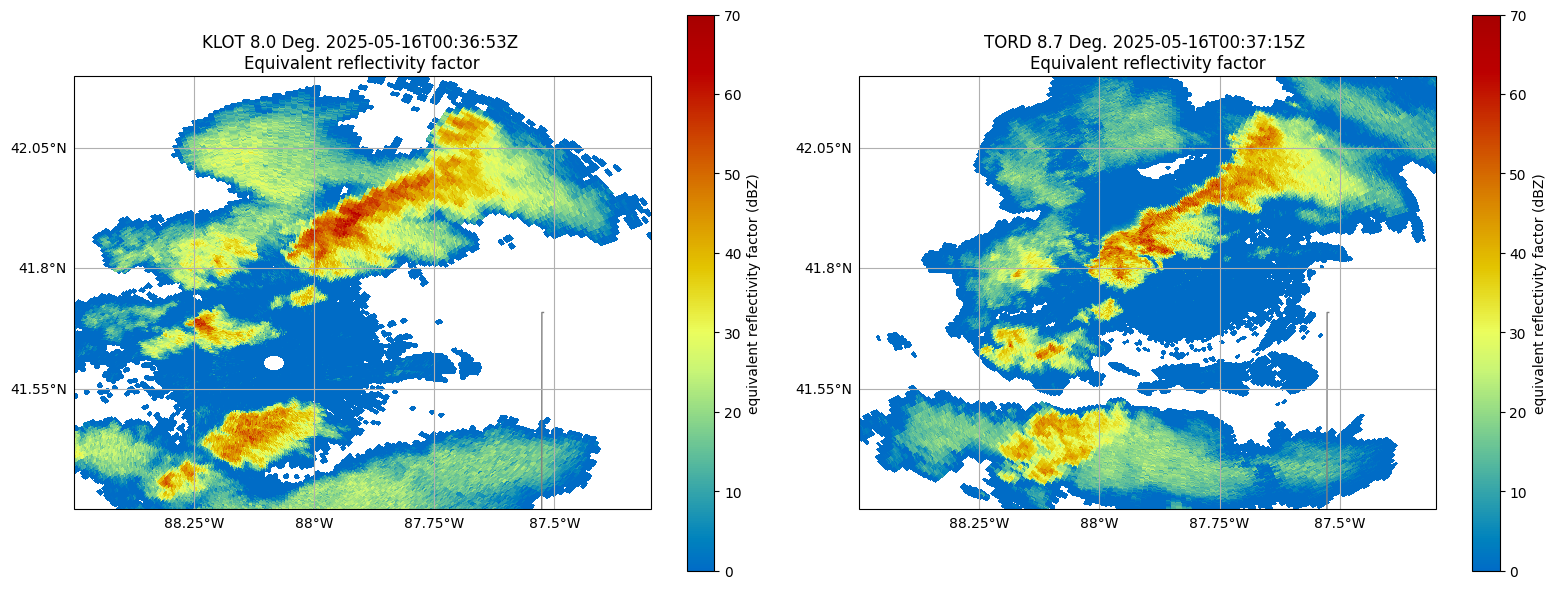

In [ ]:
#Get elevation angles
klot_elevs = klot.fixed_angle['data']
tord_elevs = tord.fixed_angle['data']

#Find closest TORD sweep to KLOT sweep 10
klot_target_sweep = 12
klot_angle = klot_elevs[klot_target_sweep]
tord_target_sweep = np.argmin(np.abs(tord_elevs - klot_angle))

#Plot reflectivity side by side
fig = plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

display1 = pyart.graph.RadarMapDisplay(klot)
display2 = pyart.graph.RadarMapDisplay(tord)

display1.plot_ppi_map(
    field='reflectivity',
    sweep=klot_target_sweep,
    ax=ax1,
    vmin=0,
    vmax=70,
    min_lat=41.3,
    max_lat=42.2,
    min_lon=-88.5,
    max_lon=-87.3,
    lat_lines=np.arange(41.3, 42.3, 0.25),
    lon_lines=np.arange(-88.5, -87.2, 0.25)
)

display2.plot_ppi_map(
    field='reflectivity',
    sweep=tord_target_sweep,
    ax=ax2,
    vmin=0,
    vmax=70,
    min_lat=41.3,
    max_lat=42.2,
    min_lon=-88.5,
    max_lon=-87.3,
    lat_lines=np.arange(41.3, 42.3, 0.25),
    lon_lines=np.arange(-88.5, -87.2, 0.25)
)

plt.tight_layout()
plt.show()

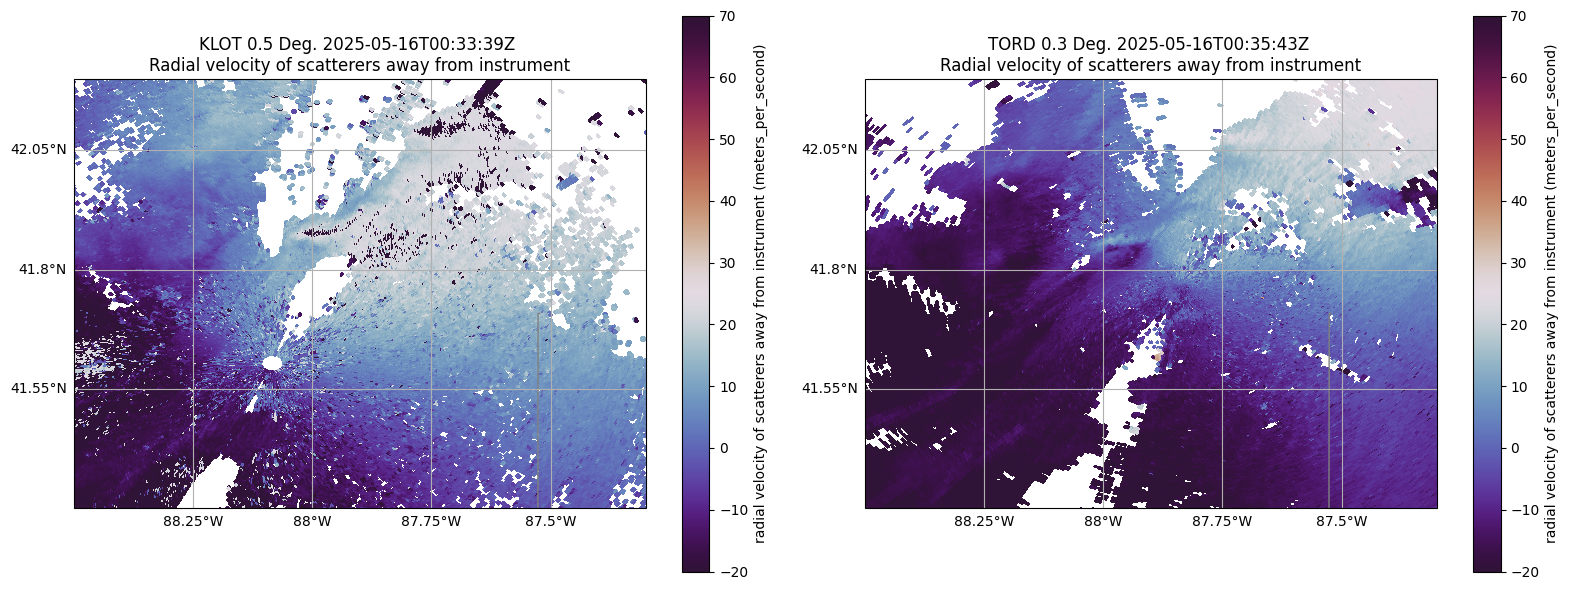

In [ ]:
fig_velocity = plt.figure(figsize=(16, 6))

vax1 = fig_velocity.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
vax2 = fig_velocity.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

display1v = pyart.graph.RadarMapDisplay(klot)
display2v = pyart.graph.RadarMapDisplay(tord)

display1v.plot_ppi_map(
    field='velocity',
    sweep=1,
    ax=vax1,
    vmin=-20,
    vmax=70,
    min_lat=41.3,
    max_lat=42.2,
    min_lon=-88.5,
    max_lon=-87.3,
    lat_lines=np.arange(41.3, 42.3, 0.25),
    lon_lines=np.arange(-88.5, -87.2, 0.25),
    cmap='twilight_shifted'
)

display2v.plot_ppi_map(
    field='velocity',
    sweep=1,
    ax=vax2,
    vmin=-20,
    vmax=70,
    min_lat=41.3,
    max_lat=42.2,
    min_lon=-88.5,
    max_lon=-87.3,
    lat_lines=np.arange(41.3, 42.3, 0.25),
    lon_lines=np.arange(-88.5, -87.2, 0.25),
    cmap='twilight_shifted'
)

plt.tight_layout()
plt.show()

##Dealiasing (KLOT)

In [ ]:
vel_tex_klot = pyart.retrieve.calculate_velocity_texture(klot,vel_field='velocity')

#Add velocity texture to the radar objects
klot.add_field('velocity_texture', vel_tex_klot, replace_existing=True)

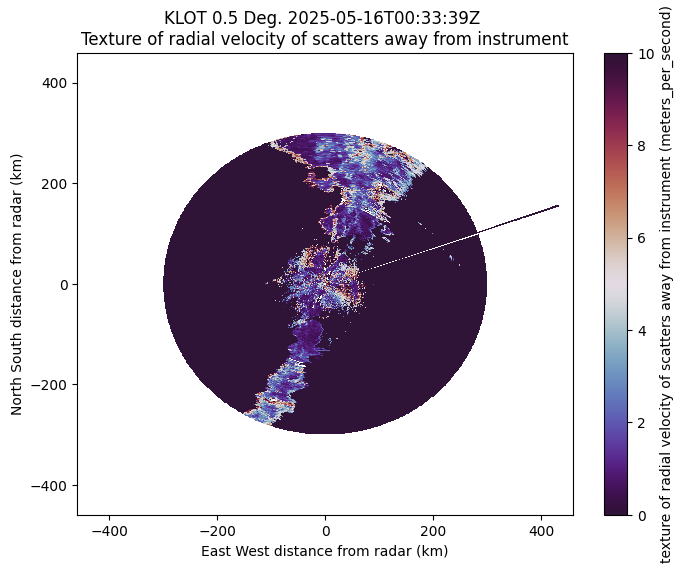

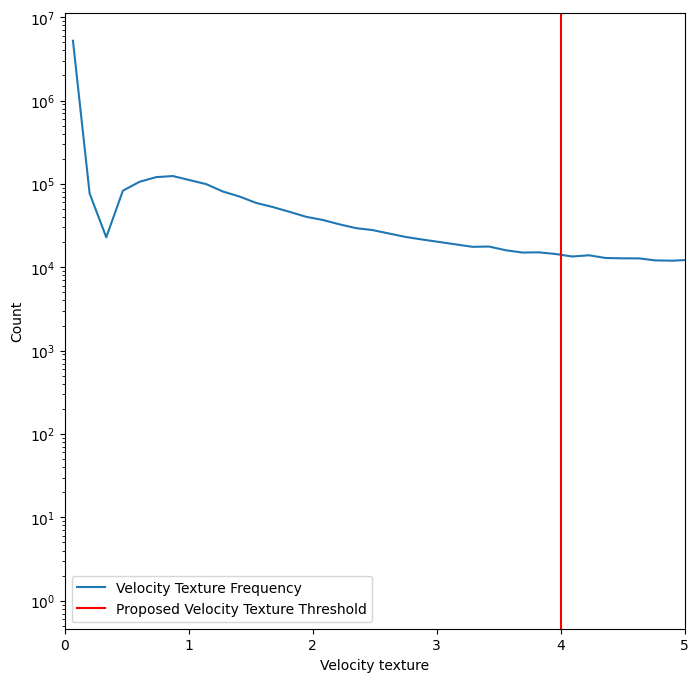

In [ ]:
#Display the calculated velocity texture
fig = plt.figure(figsize=[8, 6])
display = pyart.graph.RadarDisplay(klot)
display.plot_ppi('velocity_texture',
                     sweep=1,
                     vmin=0,
                     vmax=10,
                     cmap=plt.get_cmap('twilight_shifted')
                     )
#Plot a histogram of the velocity textures
fig = plt.figure(figsize=[8, 8])
hist, bins = np.histogram(klot.fields['velocity_texture']['data'],
                          bins=np.linspace(0, 20, 150))
bins = (bins[1:]+bins[:-1])/2.0
plt.plot(bins,
         hist,
         label='Velocity Texture Frequency'
         )
plt.axvline(4,
            color='r',
            label='Proposed Velocity Texture Threshold'
            )
plt.xlabel('Velocity texture')
plt.ylabel('Count')
plt.yscale('log')
plt.xlim(0, 5)
plt.legend()


In [ ]:
gatefilter_klot = pyart.filters.GateFilter(klot)
gatefilter_klot.exclude_above('velocity_texture', 4)

In [ ]:
vel_dealias_klot = pyart.correct.dealias_region_based(klot,
                                                      vel_field='velocity',
                                                      centered=True,
                                                      gatefilter=gatefilter_klot)

klot.add_field('corrected_velocity', vel_dealias_klot, replace_existing=True)

tord.add_field('corrected_velocity', tord.fields['velocity'], replace_existing=True)


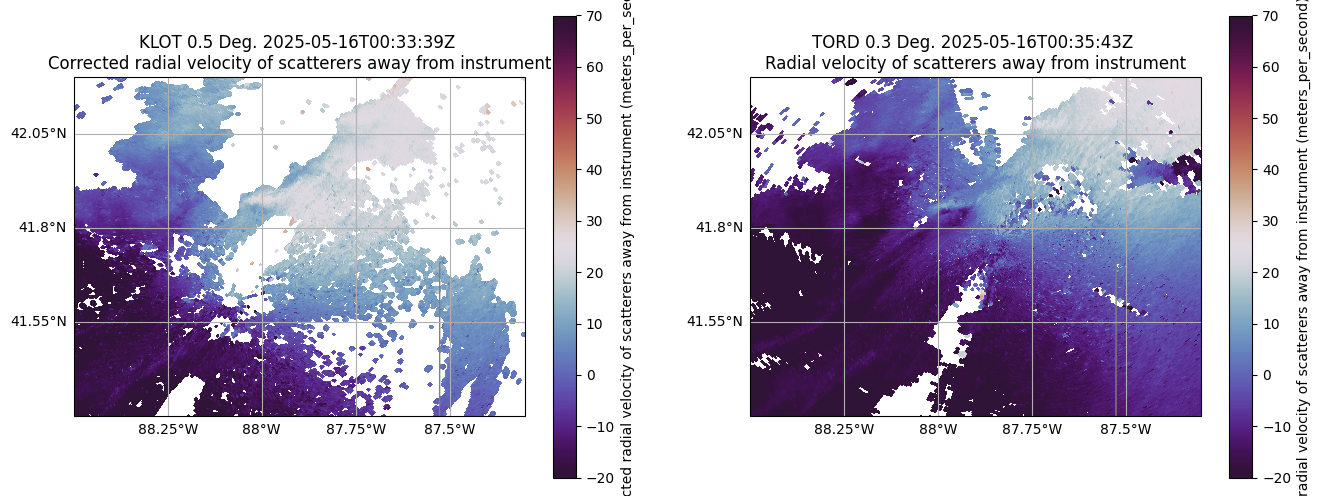

In [ ]:
#Visualize the change in aliasing
fig_velocity = plt.figure(figsize=(16, 6))

display1v = pyart.graph.RadarMapDisplay(klot)
display2v = pyart.graph.RadarMapDisplay(tord)

ax = plt.subplot(121, projection=ccrs.PlateCarree())

disp1 = pyart.graph.RadarMapDisplay(klot)

disp1.plot_ppi_map("corrected_velocity",
                   sweep=1,
                   ax=ax,
                   vmin=-20,
                   vmax=70,
                   min_lat=41.3,
                   max_lat=42.2,
                   min_lon=-88.5,
                   max_lon=-87.3,
                   lat_lines=np.arange(41.3, 42.3, 0.25),
                   lon_lines=np.arange(-88.5, -87.2, 0.25),
                   cmap=plt.get_cmap('twilight_shifted')
)
ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
disp2 = pyart.graph.RadarMapDisplay(tord)
disp2.plot_ppi_map("velocity",
                   sweep=1,
                   ax=ax2,
                   vmin=-20,
                   vmax=70,
                   min_lat=41.3,
                   max_lat=42.2,
                   min_lon=-88.5,
                   max_lon=-87.3,
                   lat_lines=np.arange(41.3, 42.3, 0.25),
                   lon_lines=np.arange(-88.5, -87.2, 0.25),
                   cmap=plt.get_cmap('twilight_shifted')
)

##Convert to Cartesian

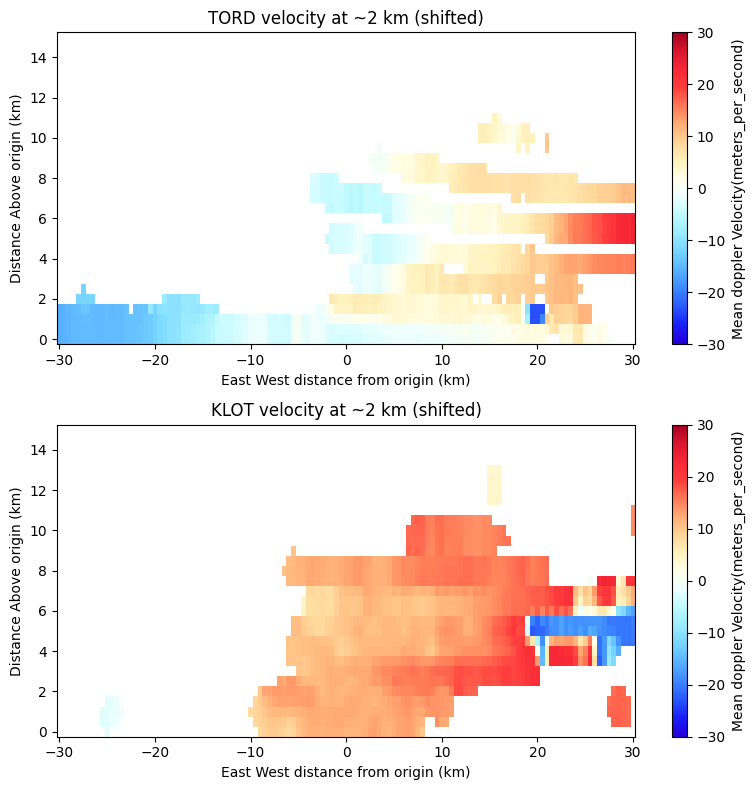

In [ ]:
gf_tord = pyart.filters.GateFilter(tord);  gf_tord.exclude_invalid('corrected_velocity')
gf_klot = pyart.filters.GateFilter(klot);  gf_klot.exclude_invalid('corrected_velocity')

grid_shape = (31, 121, 121)
grid_limits = (
  (0.0, 15000.0),
  (-30000.0, 30000.0),
  (-30000.0, 30000.0)
)

origin_lat = float(tord.latitude['data'][0])
origin_lon = float(tord.longitude['data'][0])

new_origin = (origin_lat + 0.05, origin_lon - .35)  # (up/down, left/right)

#Re‐grid each radar onto the centered mesh
grid_tord = pyart.map.grid_from_radars(
    [tord],
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    gatefilters=[gf_tord],
    grid_origin=new_origin
)
grid_klot = pyart.map.grid_from_radars(
    [klot],
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    gatefilters=[gf_klot],
    grid_origin=new_origin
)

#Find ~2 km level
z_coords = grid_tord.z['data']
idx_2km = np.argmin(np.abs(z_coords - 2000.0))

#Plot velocity slices
fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot(211)
disp1 = pyart.graph.GridMapDisplay(grid_tord)
disp1.plot_latitude_slice('velocity', lat=2000.0, ax=ax1, vmin=-30, vmax=30)
ax1.set_title("TORD velocity at ~2 km (shifted)")

ax2 = plt.subplot(212)
disp2 = pyart.graph.GridMapDisplay(grid_klot)
disp2.plot_latitude_slice('velocity', lat=2000.0, ax=ax2, vmin=-30, vmax=30)
ax2.set_title("KLOT velocity at ~2 km (shifted)")

plt.tight_layout()
plt.show()

In [ ]:
from pydda.io import read_from_pyart_grid

grid_klot_pydda = read_from_pyart_grid(grid_klot)
grid_tord_pydda = read_from_pyart_grid(grid_tord)

In [ ]:
import pandas as pd
import re
#Using sounding data

filename = "morris-05-16-0000.csv"

with open(filename, "r") as f:
    lines = f.readlines()

fields_line = next(line for line in lines if line.startswith("Fields"))
columns = [x.strip() for x in fields_line.split(",")[1:]]

data_lines = [line for line in lines if line.startswith("Data")]
data_rows = [re.split(r'\s*,\s*', line.strip())[1:] for line in data_lines]

df = pd.DataFrame(data_rows, columns=columns)

for col in ["Speed", "Direction", "Altitude", "GPSAlt"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

#Rename and clean
df.rename(columns={
    "Speed": "Speed (m/s)",
    "Direction": "Direction (deg)",
    "Altitude": "Altitude (m)",
    "GPSAlt": "GPS Alt (m)"
}, inplace=True)

df["Altitude (m)"] = df["Altitude (m)"].fillna(df["GPS Alt (m)"])
df = df.dropna(subset=["Speed (m/s)", "Direction (deg)", "Altitude (m)"])

In [ ]:
z_profile = df["Altitude (m)"].values
u_profile = -df["Speed (m/s)"] * np.sin(np.radians(df["Direction (deg)"]))
v_profile = -df["Speed (m/s)"] * np.cos(np.radians(df["Direction (deg)"]))
w_profile = np.zeros_like(z_profile)

In [ ]:
#Get the vertical levels of PyDDA grid
z_grid = grid_klot_pydda.z.values
shape = grid_klot_pydda["corrected_velocity"].shape

u_interp = np.interp(z_grid, z_profile, u_profile)
v_interp = np.interp(z_grid, z_profile, v_profile)
w_interp = np.interp(z_grid, z_profile, w_profile)

#Broadcast each to full 3D field
u_3d = np.broadcast_to(u_interp[:, None, None], shape)
v_3d = np.broadcast_to(v_interp[:, None, None], shape)
w_3d = np.broadcast_to(w_interp[:, None, None], shape)

#Inject into the PyDDA grid
grid_klot_pydda["u"] = (("time", "z", "y", "x"), u_3d)
grid_klot_pydda["v"] = (("time", "z", "y", "x"), v_3d)
grid_klot_pydda["w"] = (("time", "z", "y", "x"), w_3d)

grid_tord_pydda["u"] = (("time", "z", "y", "x"), u_3d)
grid_tord_pydda["v"] = (("time", "z", "y", "x"), v_3d)
grid_tord_pydda["w"] = (("time", "z", "y", "x"), w_3d)



In [ ]:
from pydda.retrieval import get_dd_wind_field

grids_out, _ = get_dd_wind_field(
    [grid_klot_pydda, grid_tord_pydda],
    vel_name="corrected_velocity",
    refl_field="reflectivity",
    Cm=256.0,
    Co=1e-2,
    Cx=1,
    Cy=1,
    Cz=1,
    Cb=0.1,  #uses the sounding initialization created earlier
    wind_tol=0.5,
    max_iterations=50,
    filter_window=19,
    filter_order=3,
    engine="scipy"
)


False
Calculating weights for radars 0 and 1
Calculating weights for radars 1 and 0
Calculating weights for models...
Starting solver 
rmsVR = 13.992126642926051
Total points: 154438
The max of w_init is 0.0
Total number of model points: 0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|68717.8790|   0.0000|   0.0000|785510000.0000|   0.0000|   0.0000|   0.0000|   0.0000
The gradient of the cost functions is 29.475788263425397
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|21025.0225|7341.1210|   0.0006|  29.9919|   0.0000|   0.0000|   0.0000|  91.6242
Max change in w: 75.284
The gradient of the cost functions is 3.041398007677146
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|5599.3741|3544.6411|   0.0003|11376.3028|   0.0000|   0.0000|   0.0000|  84.9600
Max change in w: 84.101
The gradient of the cost functions is 1.9860741480453767
Nfeval | 

In [ ]:
import xarray as xr

refl_0 = grids_out[0]["reflectivity"]
refl_1 = grids_out[1]["reflectivity"]
reflectivity_composite = xr.concat([refl_0, refl_1], dim='radar').max(dim='radar')

# Assign composite to grids_out[0]
grids_out[0]["reflectivity"] = reflectivity_composite

grids_out[0]["reflectivity"].attrs["long_name"] = "Equivalent Reflectivity Factor"
grids_out[0]["reflectivity"].attrs["units"] = "dBZ"

In [ ]:
threshold = 10
# Use the reflectivity from the same grid plotting from
ref = grids_out[0]["reflectivity"].isel(time=0, z=5)
mask = ref >= threshold

# Apply mask
for comp in ("u", "v"):
    da = grids_out[0][comp]
    grids_out[0][comp] = da.where(mask)

In [ ]:
import matplotlib.cm as cm

cmap = cm.get_cmap("ChaseSpectral").copy()
cmap.set_bad("white")
cmap.set_under("white")

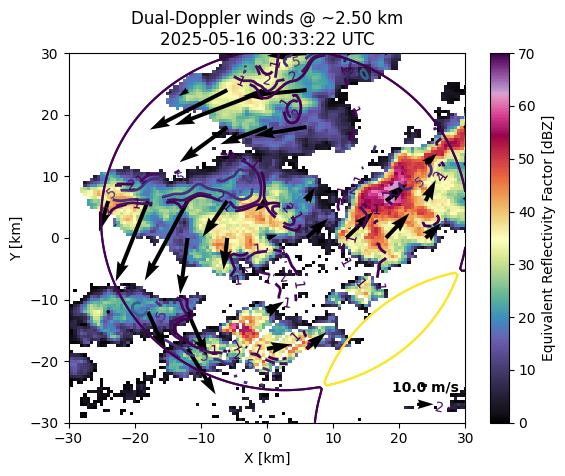

In [ ]:
import matplotlib.pyplot as plt
level = 5

ax = plot_horiz_xsection_quiver(
    grids_out, level=level, cmap=cmap, vmin=0, vmax=70,
    background_field='reflectivity', bg_grid_no=0,
    quiverkey_len=10.0, w_vel_contours=[1, 2, 5, 10, 15, 20, 25, 30],
    quiver_spacing_x_km=6.0, quiver_spacing_y_km=6.0,
    quiverkey_loc='bottom_right',
    title_flag=False
)

t0 = grids_out[0].time.values[0]
#format to a nicer string
t_str = t0.strftime("%Y-%m-%d %H:%M:%S UTC")
z_km = grids_out[0].z.values[level] / 1000.
ax.set_title(f"Dual-Doppler winds @ ~{z_km:.2f} km\n{t_str}")
plt.draw()
